In [1]:
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install torch==1.12.1
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 5.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 836.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 29.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.12
    Uninstalling fastai-2.7.12:
      Successfully uninstalled fastai-2.7.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [2]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *

from fasterai.sparse.all import *
from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fastkaggle import *

import torch
import torch.nn as nn
import torch.nn.functional as F


set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


time: 4.4 s (started: 2023-05-22 03:07:00 +00:00)


In [3]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()

time: 2.55 ms (started: 2023-05-22 03:07:04 +00:00)


In [4]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 19.8 s (started: 2023-05-22 03:07:04 +00:00)


In [5]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32)

time: 12.6 s (started: 2023-05-22 03:07:24 +00:00)


In [6]:
sp_cb=[
#       GradientAccumulation(32), 
#       SparsifyCallback(sparsity=25, 
#                          granularity='filter', 
#                          context='local', 
#                          criteria=large_final, 
#                          schedule=one_cycle),

]

time: 3.23 ms (started: 2023-05-22 03:07:36 +00:00)


In [7]:
model = vgg16_bn(num_classes=10)


time: 3.6 s (started: 2023-05-22 03:07:36 +00:00)


In [8]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ]).to_non_native_fp16()
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 14.7 ms (started: 2023-05-22 03:07:40 +00:00)


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.253166,0.176923,0.823077,2.063051,0.279808,0.720192,02:00
1,2.174489,0.213141,0.786859,2.014574,0.299519,0.700481,01:39
2,2.077919,0.244071,0.755929,1.982819,0.297115,0.702885,01:40
3,2.055564,0.261859,0.738141,1.939722,0.341346,0.658654,01:38
4,2.035084,0.280609,0.719391,1.912534,0.323077,0.676923,01:39
5,1.993335,0.293750,0.706250,1.842748,0.383654,0.616346,01:33
6,1.946820,0.312660,0.687340,1.779922,0.400000,0.600000,01:06
7,1.893730,0.332372,0.667628,1.731334,0.416827,0.583173,01:07
8,1.825490,0.359295,0.640705,1.643582,0.440865,0.559135,01:06
9,1.791056,0.379647,0.620353,1.618209,0.458654,0.541346,01:23


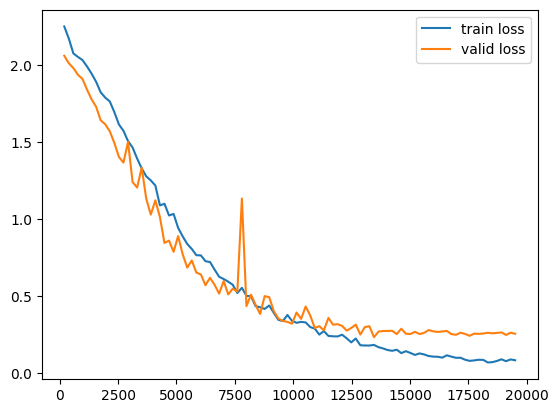

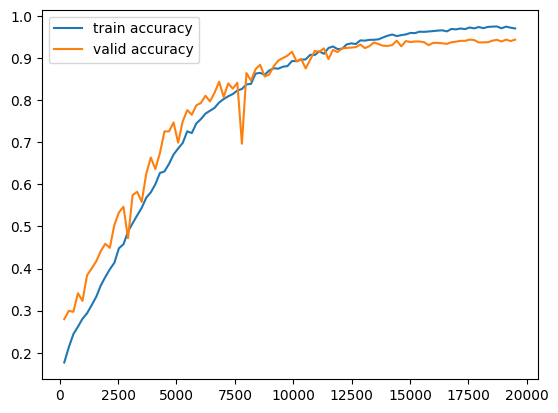

time: 2h 37s (started: 2023-05-22 03:07:40 +00:00)


In [9]:
learn.fit_one_cycle(100, 3e-5, cbs=sp_cb)
                    
learn.recorder.custom_plot_losses()
learn.recorder.custom_plot_values()

In [10]:
learn.export(Path("/kaggle/working/VGG16_bn_non_native_fp16.pkl"))

time: 1.85 s (started: 2023-05-22 05:08:18 +00:00)
